### Load the Packages

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV, Lasso

import patsy

### Fetch and Read the Files into a DataFrame

In [3]:
df = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/Rome_dfmguest.csv',
                   encoding='utf8')

In [4]:
df.shape

(15609, 18)

In [5]:
df.drop('Unnamed: 0', inplace=True, axis=1)
df.rename(columns ={'reviews_count':'review_count'},inplace=True)


In [6]:
df.head(2)

,bathrooms,bedrooms,bhk,dist_arprt,host_count,latitude,longitude,metrostn_count,minstay,neighborhood,overall_satisfaction,price,rest_count,reviews,review_count,room_id,room_type
0,1.0,0.0,1.0,0.251722,8989,41.890418,12.469850,13,3.0,Municipio 1,2.0,167.0,77,0,140078,6408911,Entire home/apt
1,1.0,1.0,1.0,0.251722,8989,41.904453,12.458648,13,3.0,Municipio 1,4.5,121.0,77,20,140078,2185484,Entire home/apt


In [7]:
#df.to_csv(path_or_buf='/Users/jyots/Desktop/DS_Projects/airbnb_datasets/Rome_IP.csv')

#### My assumption is that price value greater than 1000 USD/night is fake. Hence I am considering data where price is < 1000.

In [8]:
df = df[df.price <= 1000]


In [9]:
df.shape

(15585, 17)

### Preprocessing 

In [10]:
X = df[[x for x in df.columns if x not in ['bhk','price','latitude','longitude','room_id']]]
y = df.price.values
target = np.log(y)


#### Patsy was used for categorical data

In [11]:
formula = "target ~ "+' + '.join(X)+' -1'
formula

u'target ~ bathrooms + bedrooms + dist_arprt + host_count + metrostn_count + minstay + neighborhood + overall_satisfaction + rest_count + reviews + review_count + room_type -1'

In [12]:
y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
y = y.values.ravel()

#### Data was split into Traning and Test Data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [14]:
X_train.shape, X_test.shape

((10909, 26), (4676, 26))

In [15]:
X_test.head(2)

,neighborhood[Municipio 1],neighborhood[Municipio 10],neighborhood[Municipio 11],neighborhood[Municipio 12],neighborhood[Municipio 13],neighborhood[Municipio 14],neighborhood[Municipio 15],neighborhood[Municipio 2],neighborhood[Municipio 3],neighborhood[Municipio 4],...,bathrooms,bedrooms,dist_arprt,host_count,metrostn_count,minstay,overall_satisfaction,rest_count,reviews,review_count
7219,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.251722,8989.0,13.0,3.0,2.0,77.0,0.0,140078.0
10865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.305060,671.0,7.0,1.0,4.5,2.0,53.0,9573.0


### Regularization using Gridsearch to find an optimal ElasticNet parameters

#### Standardizing the Predictors

In [16]:
Xn = StandardScaler().fit_transform(X)

In [17]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.3)

#### Used Gridsearch to find the optimal l1 and alpha parameters

In [18]:
# enet_cv = ElasticNetCV(l1_ratio=np.linspace(0.01, 1., 50), n_alphas=300, cv=10, verbose=1, max_iter=1500)
# enet_cv.fit(Xn_train, y_train)


In [19]:
# print enet_cv.l1_ratio_
# print enet_cv.alpha_

#### Model Fitting
The values for l1 and alpha below have been obtained from Gridsearch. The R2 score of 0.52 means that the model can explain a variance of upto 52% in unknown data.

In [20]:
import time

In [21]:
start_time = time.time()


l1_ratio = 0.575714285714

alpha =0.00136892448384



enet_rome = ElasticNet(alpha= alpha, l1_ratio=l1_ratio)

y_pred_enet = enet_rome.fit(Xn_train, y_train).predict(Xn_test)
r2_score_enet = metrics.r2_score(y_test, y_pred_enet)
print(enet_rome)
print("r^2 on test data : %f" % r2_score_enet)

print("--- %s seconds ---" % (time.time() - start_time))


ElasticNet(alpha=0.00136892448384, copy_X=True, fit_intercept=True,
      l1_ratio=0.575714285714, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.523235
--- 0.17826294899 seconds ---


/Users/Jyots/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


#### The model is saved for future use

In [22]:
from sklearn.externals import joblib
#joblib.dump(enet_rome, '/Users/jyots/Desktop/DS_Projects/Models/enet_Rome.pkl') 

### Plot of Predicted Vs True Price

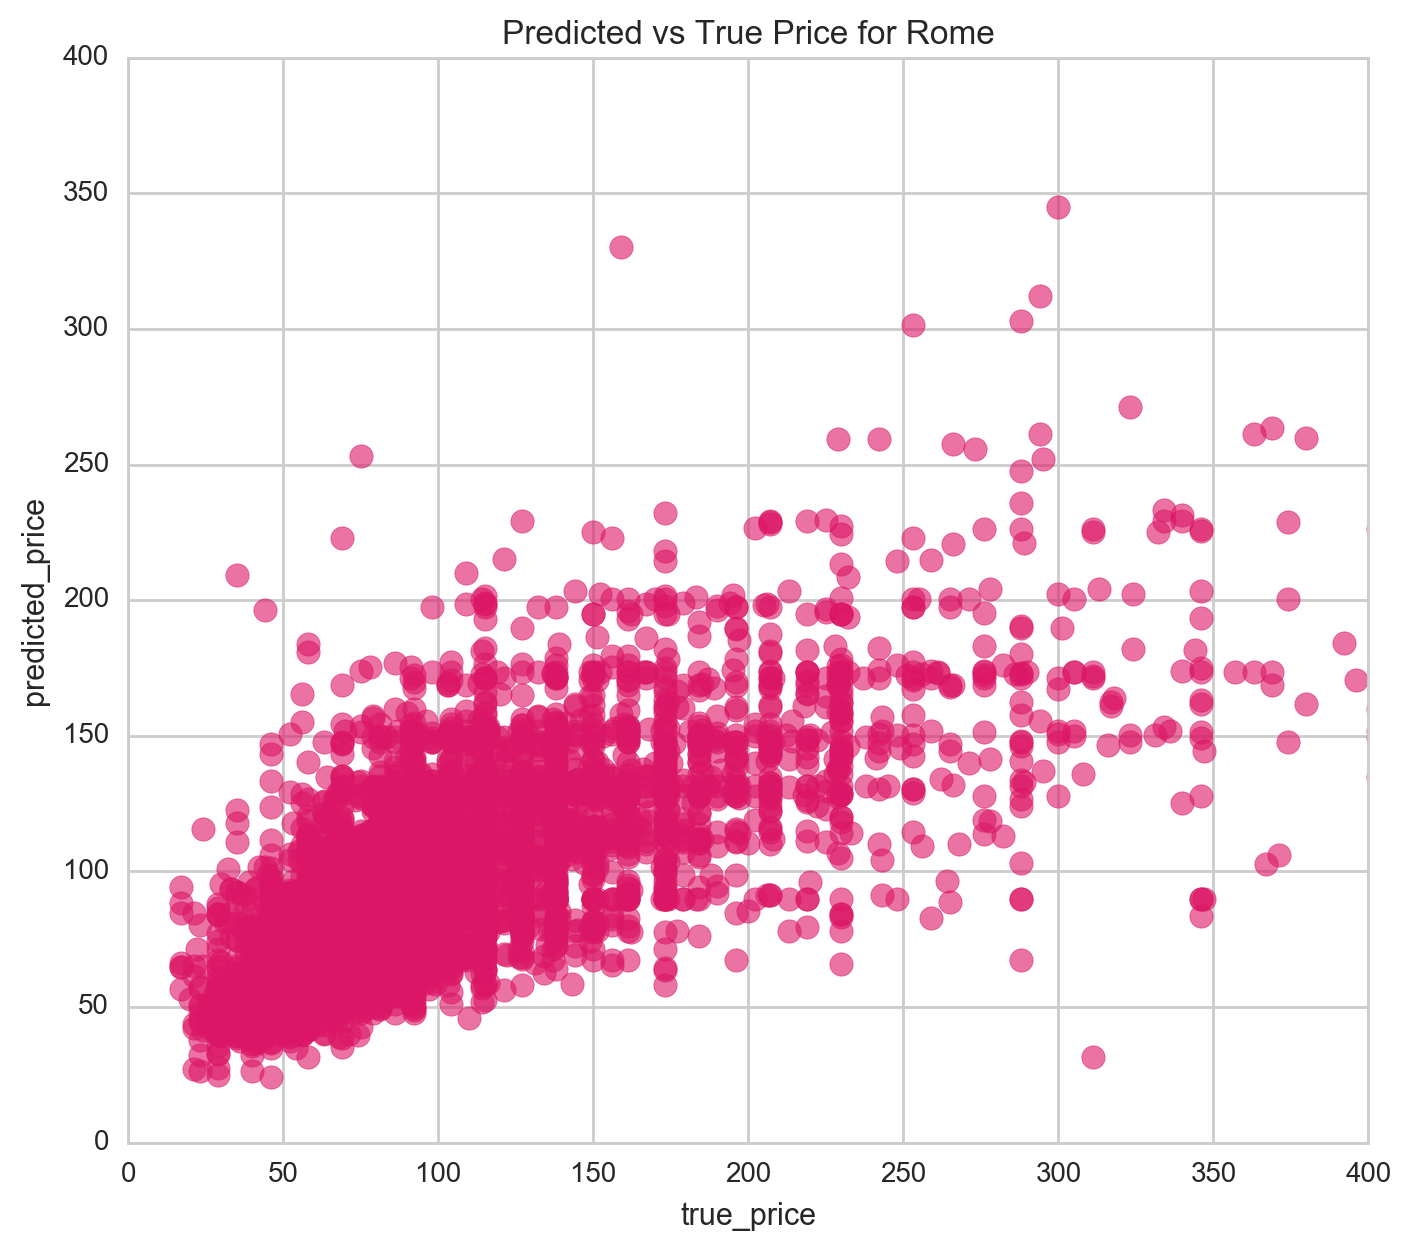

In [23]:
fig, ax = plt.subplots(figsize=(8,7))

ax.scatter(np.exp(y_test), np.exp(y_pred_enet), s=70, alpha=0.6,c='#dc1666',
          edgecolor='#dc1666'
          )

ax.set_xlabel("true_price")
ax.set_xlim([0,400])

ax.set_ylabel("predicted_price")
ax.set_ylim([0,400])


ax.set_title("Predicted vs True Price for Rome")

plt.show()


In [24]:
residuals = np.exp(y_test) - np.exp(y_pred_enet)

### Distribution Plot for Residuals

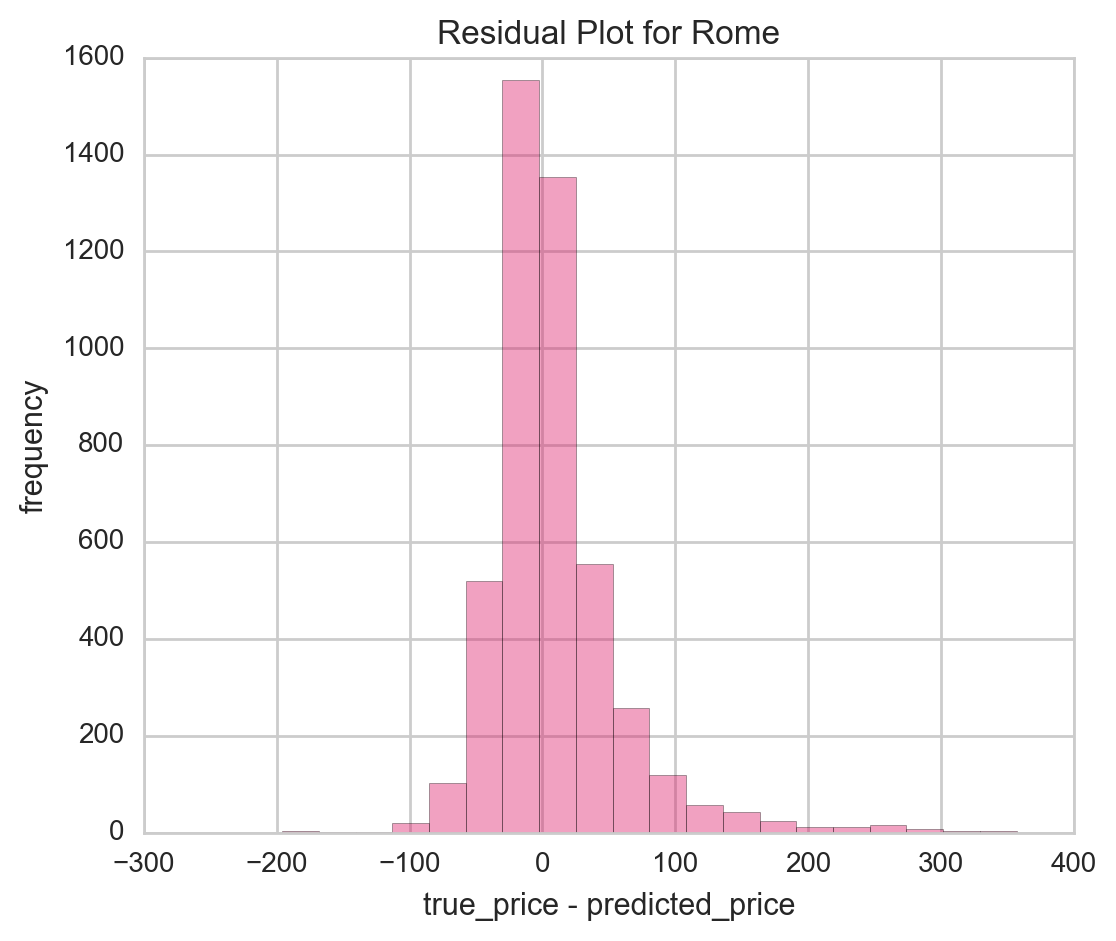

In [25]:
fig, ax = plt.subplots(figsize=(6,5))

sns.distplot(residuals, color = "#dc1666", kde=False)

ax.set_xlabel("true_price - predicted_price")
ax.set_xlim([-300,400])

ax.set_ylabel("frequency")
#ax.set_ylim([0,200])


ax.set_title("Residual Plot for Rome")

plt.show()

### Applying the model to entire Dataset for Rome

In [26]:
y_pred_enet_all = enet_rome.fit(Xn_train, y_train).predict(Xn)


#### Getting the reisduals for the entire dataset

In [27]:
residuals_all = np.exp(y) - np.exp(y_pred_enet_all)

In [28]:
len(residuals_all)

15585

#### Adding Residuals column to the original DataFrame

In [29]:
df.head(2)

,bathrooms,bedrooms,bhk,dist_arprt,host_count,latitude,longitude,metrostn_count,minstay,neighborhood,overall_satisfaction,price,rest_count,reviews,review_count,room_id,room_type
0,1.0,0.0,1.0,0.251722,8989,41.890418,12.469850,13,3.0,Municipio 1,2.0,167.0,77,0,140078,6408911,Entire home/apt
1,1.0,1.0,1.0,0.251722,8989,41.904453,12.458648,13,3.0,Municipio 1,4.5,121.0,77,20,140078,2185484,Entire home/apt


In [30]:
df['residuals'] = residuals_all

In [31]:
df.shape

(15585, 18)

#### Keeping only those rows where Residuals < 0 for obtaining the Underpriced Properties according to the model

In [32]:
df = df[df['residuals']<0]

In [33]:
df = df.reset_index(drop=True)

In [34]:
df.head(2)

,bathrooms,bedrooms,bhk,dist_arprt,host_count,latitude,longitude,metrostn_count,minstay,neighborhood,overall_satisfaction,price,rest_count,reviews,review_count,room_id,room_type,residuals
0,1.0,1.0,1.0,0.251722,8989,41.893496,12.510137,13,1.0,Municipio 1,2.0,89.0,77,0,140078,2195553,Private room,-1.000003
1,1.0,1.0,1.0,0.251722,8989,41.893488,12.464743,13,3.0,Municipio 1,5.0,104.0,77,27,140078,2212712,Entire home/apt,-2.246810


#### Converting and Saving the above DataFrame in .csv format

In [35]:
#df.to_csv(path_or_buf='/Users/jyots/Desktop/DS_Projects/airbnb_datasets/Rome_dfwithres.csv')